In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import catboost as cb
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# Funk

In [2]:
def corr(data, target):
    correlation = data.corr()
    corr_with_target = correlation[target].sort_values(ascending = False)
    print(corr_with_target)
    fig, axes = plt.subplots(figsize = (14,12))
    plt.title("Correlation of Numeric Features with target", y=1, size=16)
    sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

In [3]:
"""
ф-я определяет нелинейную связь признаков, возвращает список из 20 наиболее важных
"""
def nonlianer_comun(data, numerical, target="class", num_sign=20)-> list:
    parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}
    data = data.copy()
    data = data[numerical]
    for i in data.columns:
        data[i] = data[i].fillna(data[i].median())
    forest = RandomForestClassifier(**parameters)
    forest.fit(data.drop(target, axis=1), data[target])
    
    # numerical original
    top = []
    n_top = num_sign
    importances = forest.feature_importances_
    idx = np.argsort(importances)[::-1][0:n_top]
    feature_names = data.drop(target, axis=1).columns

    plt.figure(figsize=(20, 5))
    sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
    top.append(feature_names[idx])
    plt.title(f"What {num_sign} are the top important features to start with?", size=14)
    plt.xticks(rotation=90)
    return top, idx, importances, feature_names

In [4]:
# CatBoost
def catboost_base(x, x_val, y, y_val, cat_feature = None):
    cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.001,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": False,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
    }
    if cat_feature == None:
        model = cb.CatBoostClassifier(**cb_params)
        model.fit(x, y,
            )
    else:
        model = cb.CatBoostClassifier(**cb_params)
        model.fit(x, y,cat_features=cat_feature
            )
    y_pred = model.predict(x_val)
    print("roc_auc_score: ",roc_auc_score(y_val, y_pred))
    print("confusion_matrix: ",confusion_matrix(y_val, y_pred))
    print("accuracy_score: ",accuracy_score(y_val, y_pred))
    print("classification_report: ", classification_report(y_val, y_pred))
    return y_pred

In [5]:
# XGBoost
def xgb_base(x, x_val, y, y_val):

    params = {
    "booster": "gbtree",
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "learning_rate": 0.01,
    "nthread": 6,
    "seed": 27
    }

    dtrain = xgb.DMatrix(
    x, y
    )
    dvalid = xgb.DMatrix(
    x_val, y_val
    )

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
        early_stopping_rounds=25,
        num_boost_round=1000,
        verbose_eval=10,
        maximize=True,
    )

In [6]:
def forest_base(x, x_val, y, y_val):
    model = RandomForestClassifier(
    n_estimators=250, max_depth=8, n_jobs=6, random_state=27
    )
    model.fit(x, y)
    y_pred = model.predict(x_val)
    print("roc_auc_score: ",roc_auc_score(y_val, y_pred))
    print("confusion_matrix: ",confusion_matrix(y_val, y_pred))
    print("accuracy_score: ",accuracy_score(y_val, y_pred))

In [7]:
def train_split(x):
    x_train, x_valid, y_train, y_valid = train_test_split(x.drop( "target", axis=1), x["target"], test_size = 0.2)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2)
    print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape, x_test.shape, y_test.shape)
    return x_train, x_valid, y_train, y_valid, x_test, y_test

In [8]:
def train_split_dis(x):
    for i in range(10000000):
        x_train, x_valid, y_train, y_valid = train_test_split(x.drop( "target", axis=1), x["target"], test_size = 0.3,
                                                             random_state = i)
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2)
        if (y_train == 1).sum()/181 < 0.7:
            print("random_state: {}".format(i))
            print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape, x_test.shape, y_test.shape)
            return x_train, x_valid, y_train, y_valid, x_test, y_test


# read data

In [9]:
data = pd.read_csv("data/data_n.csv")

In [10]:
print(data.shape)
data.head(n=2)

(10234, 105)


,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,d1_sodium_min,d1_wbc_max,d1_wbc_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,target
0,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,Accident & Emergency,...,130.0,5.6,5.4,0,0,0,0,0,0,0
1,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,Accident & Emergency,...,144.0,NaN,NaN,0,0,0,0,0,0,0


In [9]:
check_sign = []
for i in data:
    pr = round(data[i].isna().sum()/ data.shape[0] * 100,2)
    print(i)
    print("кол-во: ",data[i].isna().sum(),"процент: ", pr)
    if pr > 10:
        check_sign.append(i)
    

encounter_id
кол-во:  0 процент:  0.0
hospital_id
кол-во:  0 процент:  0.0
age
кол-во:  0 процент:  0.0
bmi
кол-во:  1015 процент:  9.92
elective_surgery
кол-во:  0 процент:  0.0
ethnicity
кол-во:  204 процент:  1.99
gender
кол-во:  5 процент:  0.05
height
кол-во:  301 процент:  2.94
hospital_admit_source
кол-во:  2733 процент:  26.71
icu_admit_source
кол-во:  25 процент:  0.24
icu_id
кол-во:  0 процент:  0.0
icu_stay_type
кол-во:  0 процент:  0.0
icu_type
кол-во:  0 процент:  0.0
pre_icu_los_days
кол-во:  0 процент:  0.0
readmission_status
кол-во:  0 процент:  0.0
weight
кол-во:  908 процент:  8.87
apache_2_diagnosis
кол-во:  170 процент:  1.66
apache_3j_diagnosis
кол-во:  108 процент:  1.06
apache_post_operative
кол-во:  0 процент:  0.0
arf_apache
кол-во:  0 процент:  0.0
bun_apache
кол-во:  2061 процент:  20.14
creatinine_apache
кол-во:  2043 процент:  19.96
gcs_eyes_apache
кол-во:  205 процент:  2.0
gcs_motor_apache
кол-во:  205 процент:  2.0
gcs_unable_apache
кол-во:  61 процент: 

In [10]:
len(check_sign)

33

In [11]:
categorical_check_sign = data[check_sign].dtypes[data[check_sign].dtypes == "object"].index
numerical_check_sign = list(set(check_sign) - set(categorical_check_sign))

print(f"Всего категориальных признаков: {len(categorical_check_sign)}")
print(f"Всего числовых признаков: {len(numerical_check_sign)}")

Всего категориальных признаков: 1
Всего числовых признаков: 32


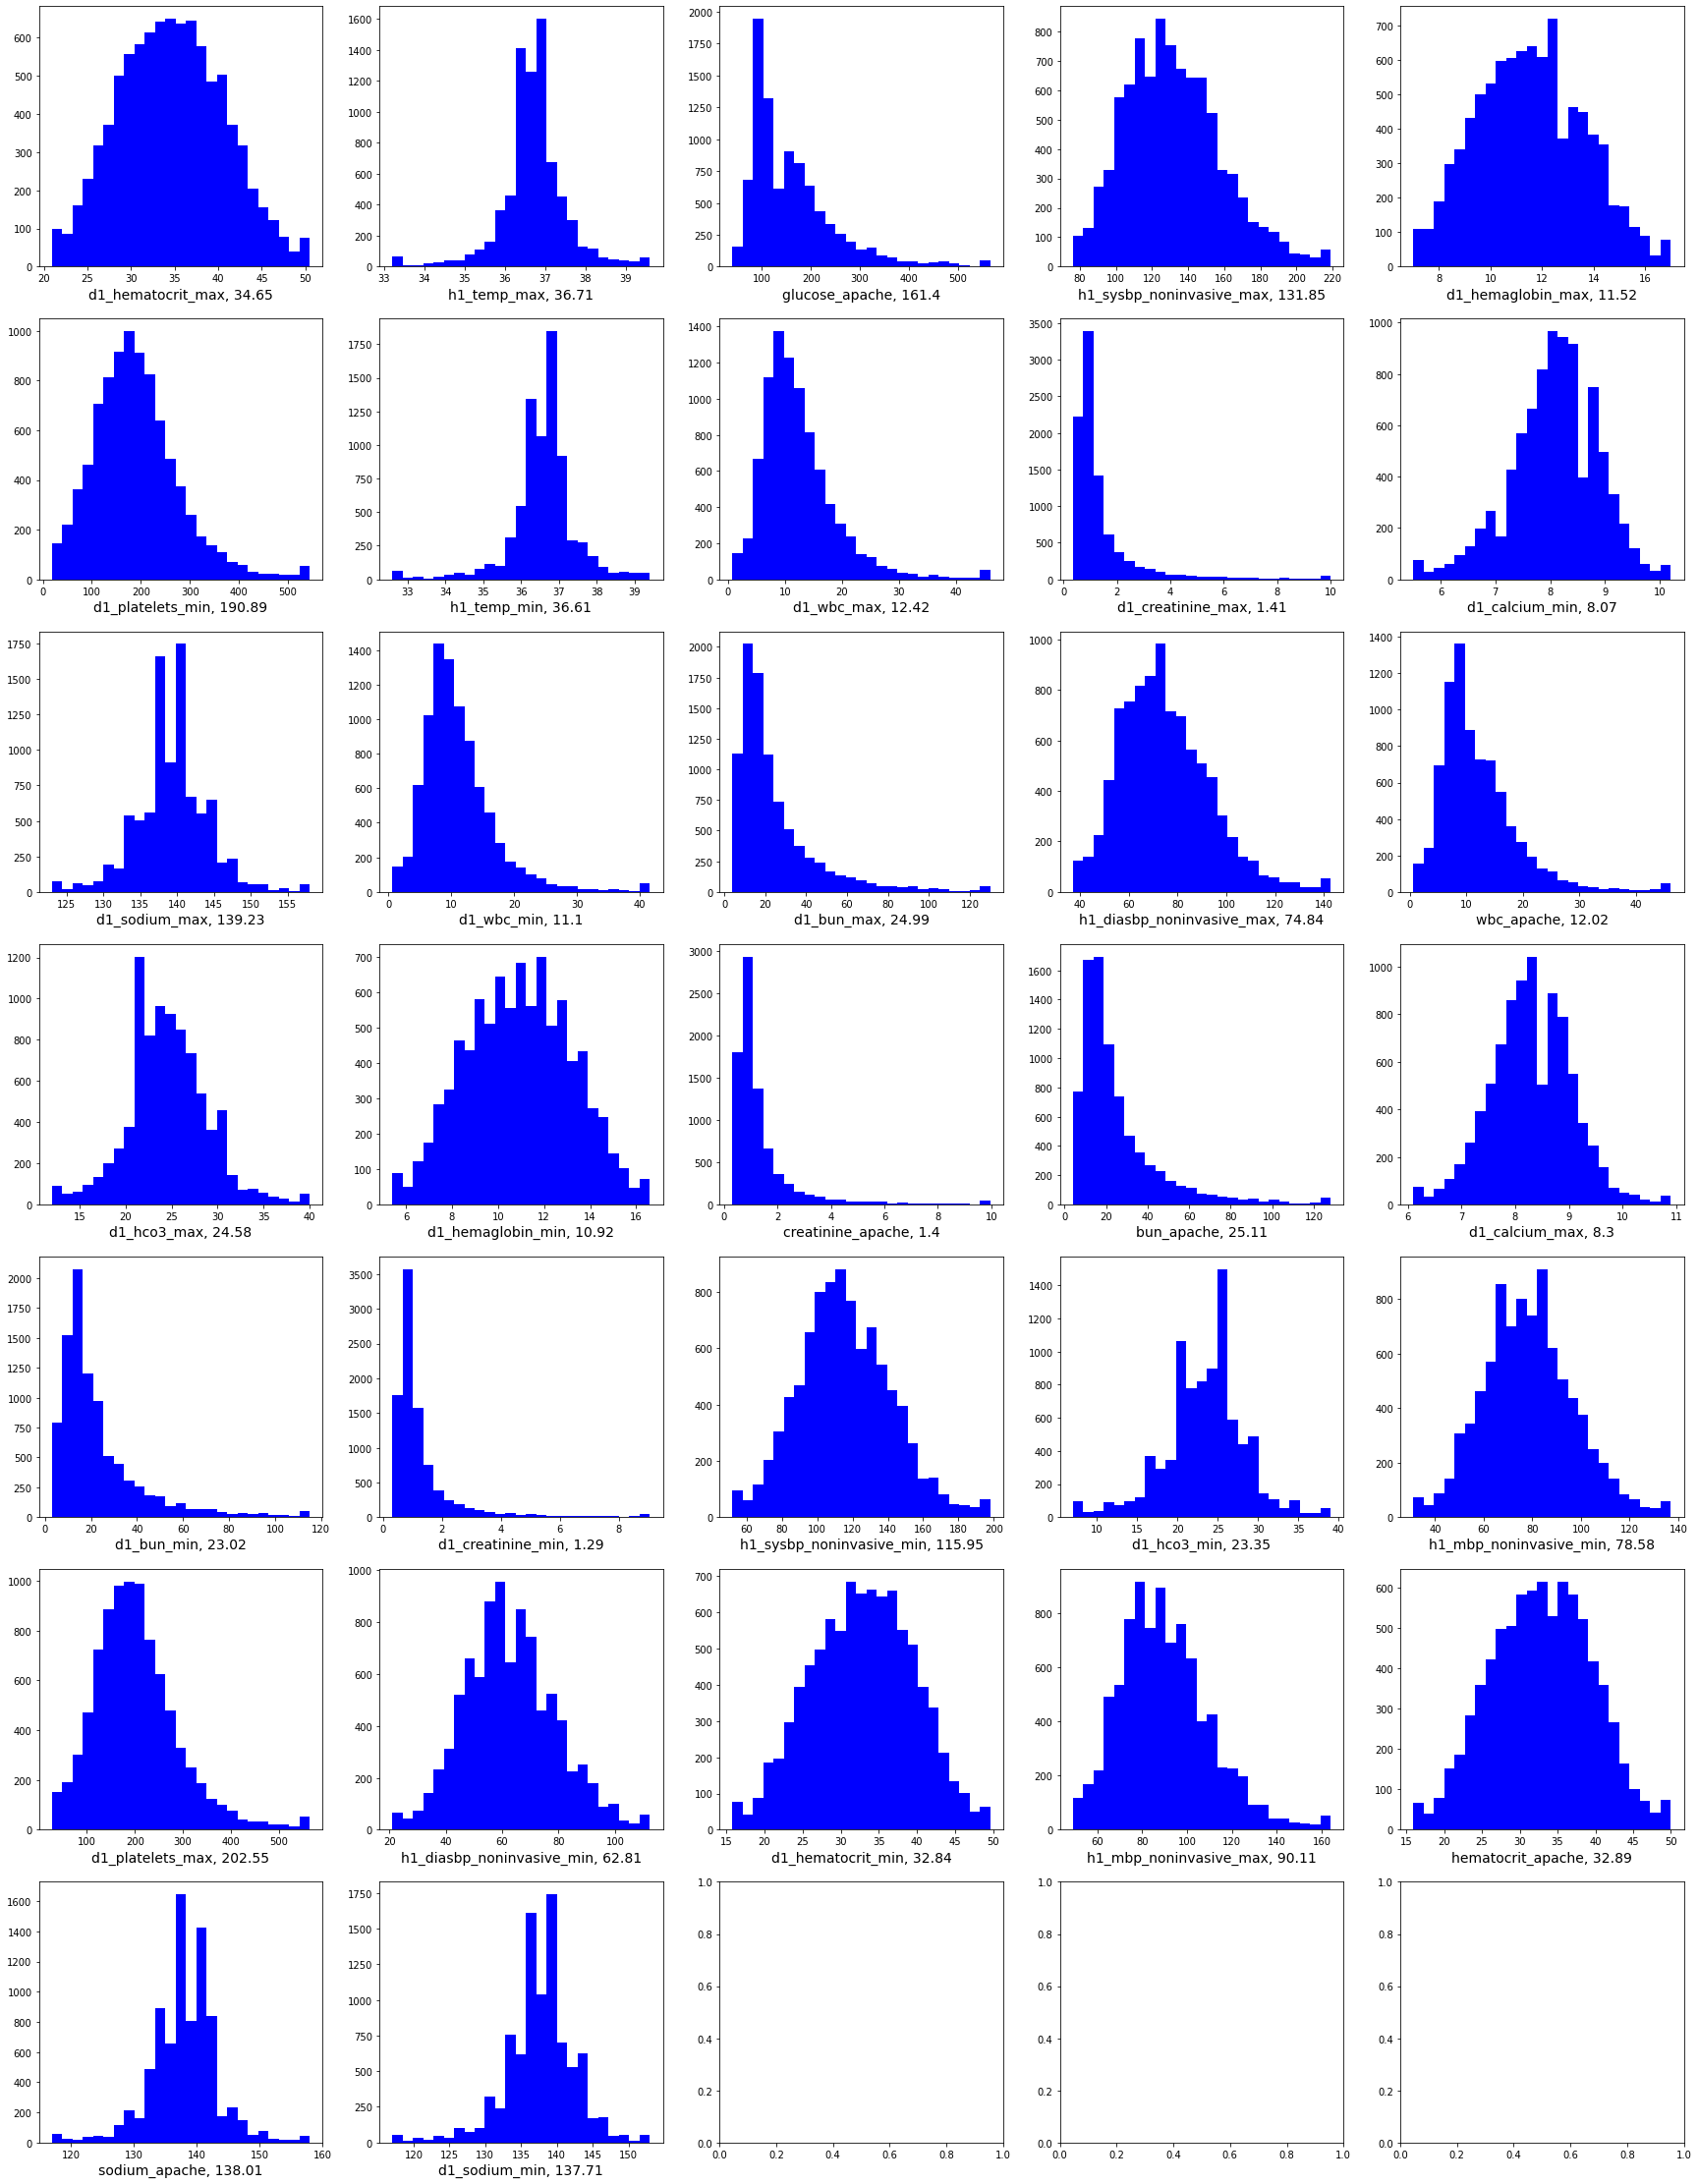

In [12]:
fig, axes = plt.subplots(7, 5,figsize=(30, 40))

for num, feature in enumerate(numerical_check_sign):
    df = data[feature].copy()
    mean_ = round(df.mean(), 2)
#     print(axes)
    axes[num//5, num%5].hist(df, bins=25, color="blue")
    axes[num//5, num%5].set_xlabel(f"{feature}, {mean_}", fontsize=14)

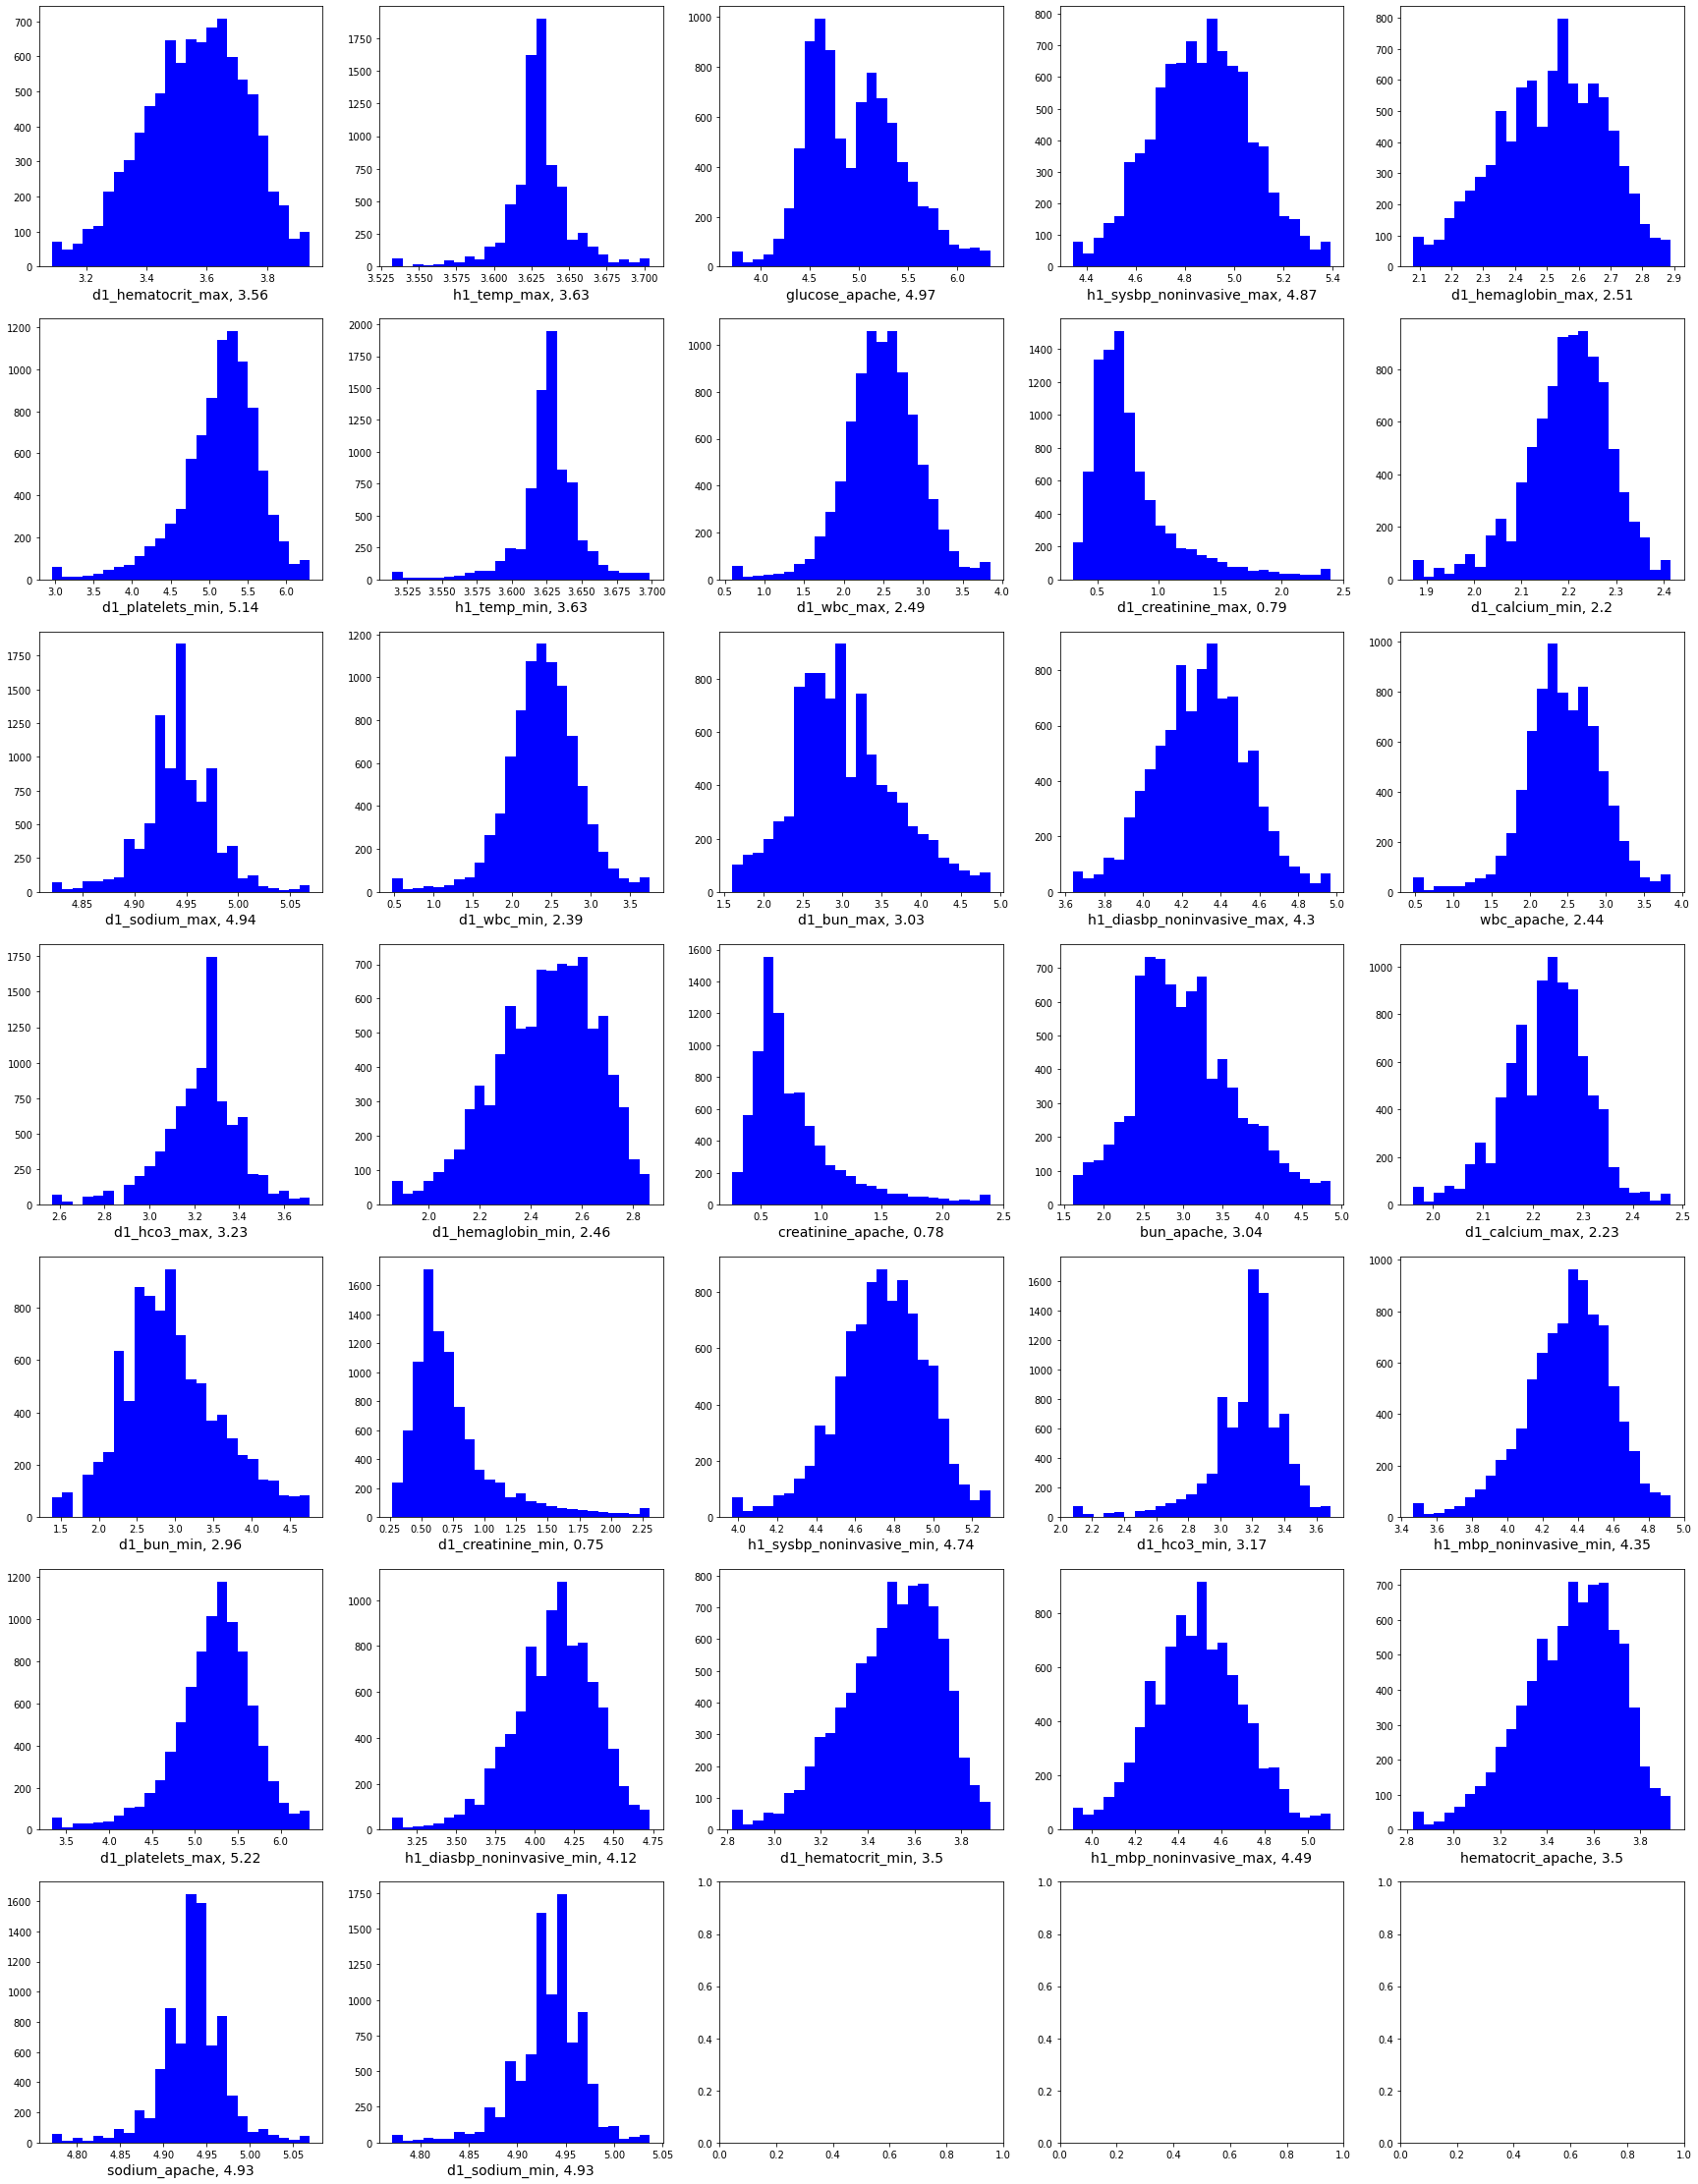

In [13]:
fig, axes = plt.subplots(7, 5,figsize=(30, 40))

for num, feature in enumerate(numerical_check_sign):
    df = np.log(data[feature].copy() + 1)
    mean_ = round(df.mean(), 2)
#     print(axes)
    axes[num//5, num%5].hist(df, bins=25, color="blue")
    axes[num//5, num%5].set_xlabel(f"{feature}, {mean_}", fontsize=14)

In [14]:
print(data[categorical_check_sign].isna().sum(), data.shape[0])
data[categorical_check_sign].value_counts()

hospital_admit_source    2733
dtype: int64 10234


hospital_admit_source
Emergency Department     3845
Floor                    1121
Operating Room           1110
Direct Admit              696
Recovery Room             405
Other Hospital            173
Step-Down Unit (SDU)       99
Chest Pain Center          23
Other ICU                  23
ICU to SDU                  6
dtype: int64

In [15]:
categorical = data.dtypes[data.dtypes == "object"].index
numerical = list(set(data.columns) - set(categorical))

print(f"Всего категориальных признаков: {len(categorical)}")
print(f"Всего числовых признаков: {len(numerical)}")


Всего категориальных признаков: 6
Всего числовых признаков: 99


In [16]:
del_list = ["encounter_id", "hospital_id", "target"]
num = [i for i in numerical if i not in del_list]
df = data.copy()
df[num] = df[num].apply(lambda x: np.log(x + 1))

In [17]:
df.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,d1_sodium_min,d1_wbc_max,d1_wbc_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,target
0,144740,10141,4.290459,NaN,0.0,Caucasian,F,5.033049,Floor,Accident & Emergency,...,4.875197,1.887070,1.856298,0.0,0.0,0.0,0.0,0.0,0.0,0
1,141990,10141,4.465908,NaN,0.0,Caucasian,F,5.172187,Emergency Department,Accident & Emergency,...,4.976734,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0
2,142038,10141,4.290459,NaN,0.0,Caucasian,F,5.097424,Floor,Floor,...,4.927254,2.028148,1.722767,0.0,0.0,0.0,0.0,0.0,0.0,0
3,138628,10141,4.204693,NaN,0.0,Caucasian,M,5.186268,Floor,Floor,...,4.919981,3.250374,3.250374,0.0,0.0,0.0,0.0,0.0,0.0,0
4,141682,10141,4.499810,NaN,0.0,Caucasian,M,5.142832,Direct Admit,Accident & Emergency,...,4.897840,1.974081,1.824549,0.0,0.0,0.0,0.0,0.0,0.0,0


In [18]:
for i in df:
    print(i, ": ", df[i].isna().sum())

encounter_id :  0
hospital_id :  0
age :  0
bmi :  1015
elective_surgery :  0
ethnicity :  204
gender :  5
height :  301
hospital_admit_source :  2733
icu_admit_source :  25
icu_id :  0
icu_stay_type :  0
icu_type :  0
pre_icu_los_days :  0
readmission_status :  0
weight :  908
apache_2_diagnosis :  170
apache_3j_diagnosis :  108
apache_post_operative :  0
arf_apache :  0
bun_apache :  2061
creatinine_apache :  2043
gcs_eyes_apache :  205
gcs_motor_apache :  205
gcs_unable_apache :  61
gcs_verbal_apache :  205
glucose_apache :  1210
heart_rate_apache :  30
hematocrit_apache :  2114
intubated_apache :  0
map_apache :  52
resprate_apache :  64
sodium_apache :  1993
temp_apache :  671
ventilated_apache :  0
wbc_apache :  2376
d1_diasbp_max :  23
d1_diasbp_min :  23
d1_diasbp_noninvasive_max :  149
d1_diasbp_noninvasive_min :  149
d1_heartrate_max :  24
d1_heartrate_min :  24
d1_mbp_max :  37
d1_mbp_min :  37
d1_mbp_noninvasive_max :  212
d1_mbp_noninvasive_min :  212
d1_resprate_max :  55

# Замена пропусков

In [19]:
df_median = df.copy()
for i in df_median[numerical]:
    df_median[i] = df_median[i].fillna(df[i].median())
# df_median[numerical] = df_median[numerical].apply(lambda x: df_median[x].fillna(df_median[x].median()))
# df_median[numerical] = [df_median[i].fillna(df[i].median) for i in df_median[numerical]]

In [20]:
for i in df_median:
    print(i, ": ", df_median[i].isna().sum())

encounter_id :  0
hospital_id :  0
age :  0
bmi :  0
elective_surgery :  0
ethnicity :  204
gender :  5
height :  0
hospital_admit_source :  2733
icu_admit_source :  25
icu_id :  0
icu_stay_type :  0
icu_type :  0
pre_icu_los_days :  0
readmission_status :  0
weight :  0
apache_2_diagnosis :  0
apache_3j_diagnosis :  0
apache_post_operative :  0
arf_apache :  0
bun_apache :  0
creatinine_apache :  0
gcs_eyes_apache :  0
gcs_motor_apache :  0
gcs_unable_apache :  0
gcs_verbal_apache :  0
glucose_apache :  0
heart_rate_apache :  0
hematocrit_apache :  0
intubated_apache :  0
map_apache :  0
resprate_apache :  0
sodium_apache :  0
temp_apache :  0
ventilated_apache :  0
wbc_apache :  0
d1_diasbp_max :  0
d1_diasbp_min :  0
d1_diasbp_noninvasive_max :  0
d1_diasbp_noninvasive_min :  0
d1_heartrate_max :  0
d1_heartrate_min :  0
d1_mbp_max :  0
d1_mbp_min :  0
d1_mbp_noninvasive_max :  0
d1_mbp_noninvasive_min :  0
d1_resprate_max :  0
d1_resprate_min :  0
d1_spo2_max :  0
d1_spo2_min :  0


In [21]:
for i in categorical:
    print(f"sign: {i}")
    print(df_median[i].isna().sum())
    print(df_median[i].nunique())
    print(df_median[i].value_counts())

sign: ethnicity
204
6
Caucasian           7939
African American     931
Hispanic             471
Other/Unknown        435
Asian                171
Native American       83
Name: ethnicity, dtype: int64
sign: gender
5
2
M    5525
F    4704
Name: gender, dtype: int64
sign: hospital_admit_source
2733
10
Emergency Department    3845
Floor                   1121
Operating Room          1110
Direct Admit             696
Recovery Room            405
Other Hospital           173
Step-Down Unit (SDU)      99
Other ICU                 23
Chest Pain Center         23
ICU to SDU                 6
Name: hospital_admit_source, dtype: int64
sign: icu_admit_source
25
5
Accident & Emergency         5974
Operating Room / Recovery    2258
Floor                        1656
Other Hospital                253
Other ICU                      68
Name: icu_admit_source, dtype: int64
sign: icu_stay_type
0
3
admit       10088
transfer      121
readmit        25
Name: icu_stay_type, dtype: int64
sign: icu_type
0
8


In [22]:
2733/3845

0.7107932379713914

* стоит удалить hospital_admit_source, тк если добавить их в моду значение в признаке увеличется на 70%

In [23]:
df_median = df_median.drop("hospital_admit_source", axis=1)

In [24]:
categorical = list(categorical)

In [25]:
categorical.remove("hospital_admit_source")

In [26]:
categorical

['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type']

In [27]:
df_median[categorical] = df_median[categorical].astype(str)

In [28]:
# for column in df_median:
#     df_median[column].fillna(df_median[column].mode()[0], inplace=True)

In [29]:
df_median[categorical].loc[df_median["ethnicity"] =="Caucasian" ]

,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type
0,Caucasian,F,Accident & Emergency,admit,Med-Surg ICU
1,Caucasian,F,Accident & Emergency,admit,Med-Surg ICU
2,Caucasian,F,Floor,admit,Med-Surg ICU
3,Caucasian,M,Floor,admit,Med-Surg ICU
4,Caucasian,M,Accident & Emergency,admit,Med-Surg ICU
...,...,...,...,...,...
10229,Caucasian,F,Floor,admit,Med-Surg ICU
10230,Caucasian,F,Accident & Emergency,admit,Med-Surg ICU
10231,Caucasian,F,Floor,admit,Med-Surg ICU
10232,Caucasian,F,Accident & Emergency,admit,Med-Surg ICU


In [30]:
for i in df_median:
    check = df_median[i].isna().sum()
    if check != 0:
        print(i)
        print(df_median[i].isna().sum())


# Обучение

In [31]:
x_train, x_valid, y_train, y_valid, x_test, y_test = train_split(df_median)

(6549, 103) (2047, 103) (6549,) (2047,) (1638, 103) (1638,)


In [32]:
print((df_median['target'] == 1).sum())
(y_train == 1).sum()

181


118

In [33]:
pred = catboost_base(x_train, x_valid, y_train, y_valid, categorical)

roc_auc_score:  0.5
confusion_matrix:  [[2017    0]
 [  30    0]]
accuracy_score:  0.9853444064484611
classification_report:                precision    recall  f1-score   support

           0       0.99      1.00      0.99      2017
           1       0.00      0.00      0.00        30

    accuracy                           0.99      2047
   macro avg       0.49      0.50      0.50      2047
weighted avg       0.97      0.99      0.98      2047



c:\program files\python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
print(classification_report(y_valid, pred, labels=np.unique(pred)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2017

   micro avg       0.99      1.00      0.99      2017
   macro avg       0.99      1.00      0.99      2017
weighted avg       0.99      1.00      0.99      2017



# catboost class_weights

In [35]:
# class_weights

# CatBoost
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.001,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": False,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42,
    "class_weights":(1,56)
    }



In [36]:
print((y_train==1).sum())
print((y_train==0).sum())
(y_train==0).sum() // (y_train==1).sum()

118
6431


54

In [37]:
model_cb_w = cb.CatBoostClassifier(**cb_params)
model_cb_w.fit(x_train, 
               y_train,
               cat_features=categorical, 
               eval_set = [(x_train, y_train), (x_valid, y_valid)], 
               plot= True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [38]:
pred = model_cb_w.predict(x_test)
print(classification_report(y_test, pred, labels=np.unique(pred)))
print("roc_auc_score: ",roc_auc_score(y_test, pred))
print("confusion_matrix: ",confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1605
           1       0.21      0.21      0.21        33

    accuracy                           0.97      1638
   macro avg       0.60      0.60      0.60      1638
weighted avg       0.97      0.97      0.97      1638

roc_auc_score:  0.5979609175870858
confusion_matrix:  [[1579   26]
 [  26    7]]


In [39]:
model_cb_w.set_probability_threshold(0.8)
pred = model_cb_w.predict(x_test)
print(classification_report(y_test, pred, labels=np.unique(pred)))
print("roc_auc_score: ",roc_auc_score(y_test, pred))
print("confusion_matrix: ",confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1605

   micro avg       0.98      1.00      0.99      1605
   macro avg       0.98      1.00      0.99      1605
weighted avg       0.98      1.00      0.99      1605

roc_auc_score:  0.5
confusion_matrix:  [[1605    0]
 [  33    0]]


In [40]:
model_cb_w.set_probability_threshold(0.4)
pred = model_cb_w.predict(x_test)
print(classification_report(y_test, pred, labels=np.unique(pred)))
print("roc_auc_score: ",roc_auc_score(y_test, pred))
print("confusion_matrix: ",confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           1       0.02      1.00      0.04        33

   micro avg       0.02      1.00      0.04        33
   macro avg       0.02      1.00      0.04        33
weighted avg       0.02      1.00      0.04        33

roc_auc_score:  0.5
confusion_matrix:  [[   0 1605]
 [   0   33]]


In [41]:
model_cb_w.set_probability_threshold(0.4)
pred = model_cb_w.predict(x_test)
print(classification_report(y_test, pred, labels=np.unique(pred)))
print("roc_auc_score: ",roc_auc_score(y_test, pred))
print("confusion_matrix: ",confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           1       0.02      1.00      0.04        33

   micro avg       0.02      1.00      0.04        33
   macro avg       0.02      1.00      0.04        33
weighted avg       0.02      1.00      0.04        33

roc_auc_score:  0.5
confusion_matrix:  [[   0 1605]
 [   0   33]]


# imbalance class

In [42]:
df_median["target"].value_counts()

0    10053
1      181
Name: target, dtype: int64

In [43]:
newdf = pd.DataFrame(np.repeat(df_median.loc[df_median['target'] == 1].values, 3, axis=0))
newdf.columns = df_median.columns
print(newdf.shape)
newdf.head()

(543, 104)


,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_id,...,d1_sodium_min,d1_wbc_max,d1_wbc_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,target
0,143445,10166,3.637586,3.353407,0.0,Caucasian,F,5.097424,Floor,4.564348,...,4.941642,1.94591,1.94591,0.0,0.0,0.0,0.693147,0.0,0.0,1
1,143445,10166,3.637586,3.353407,0.0,Caucasian,F,5.097424,Floor,4.564348,...,4.941642,1.94591,1.94591,0.0,0.0,0.0,0.693147,0.0,0.0,1
2,143445,10166,3.637586,3.353407,0.0,Caucasian,F,5.097424,Floor,4.564348,...,4.941642,1.94591,1.94591,0.0,0.0,0.0,0.693147,0.0,0.0,1
3,145267,10156,4.110874,3.353407,0.0,Caucasian,M,5.172187,Accident & Emergency,4.51086,...,4.934474,2.292535,2.292535,0.0,0.0,0.0,0.0,0.0,0.0,1
4,145267,10156,4.110874,3.353407,0.0,Caucasian,M,5.172187,Accident & Emergency,4.51086,...,4.934474,2.292535,2.292535,0.0,0.0,0.0,0.0,0.0,0.0,1


In [44]:
df_balance_1 = df_median.loc[df_median['target'] == 0].sample(n= 500)

In [45]:
data_balance = pd.concat([df_balance_1, newdf])

In [46]:
print(data_balance.shape)
data_balance["target"].value_counts()

(1043, 104)


1    543
0    500
Name: target, dtype: int64

In [47]:
x_train, x_valid, y_train, y_valid, x_test, y_test = train_split(data_balance)

(667, 103) (209, 103) (667,) (209,) (167, 103) (167,)


In [48]:
# x_train, x_valid, y_train, y_valid = train_test_split(data_balance.drop( "target", axis=1), data_balance["target"], test_size = 0.2)
# x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

In [49]:
model_cb_balance = cb.CatBoostClassifier(**cb_params)
model_cb_balance.fit(x_train, 
                     y_train,
                     cat_features=categorical,
                     eval_set =[(x_train, y_train), (x_valid, y_valid)], 
                     plot= True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [50]:
y_test = y_test.astype("float64")

In [51]:
pred = model_cb_balance.predict(x_test)
print(classification_report(y_test, pred))
print("roc_auc_score: ",roc_auc_score(y_test, pred))
print("confusion_matrix: ",confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        88
         1.0       0.47      1.00      0.64        79

    accuracy                           0.47       167
   macro avg       0.24      0.50      0.32       167
weighted avg       0.22      0.47      0.30       167

roc_auc_score:  0.5
confusion_matrix:  [[ 0 88]
 [ 0 79]]


c:\program files\python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# non_lianer

In [52]:
non_lianer = ['immunosuppression', 'd1_wbc_max', 'wbc_apache', 'd1_heartrate_min',
         'd1_platelets_min', 'heart_rate_apache', 'hospital_id', 'd1_wbc_min',
         'd1_mbp_noninvasive_max', 'icu_id', 'd1_mbp_min', 'd1_platelets_max',
         'h1_heartrate_min', 'd1_potassium_min', 'd1_sysbp_max',
         'h1_sysbp_noninvasive_max', 'h1_diasbp_max', 'resprate_apache',
         'encounter_id', 'd1_hematocrit_max', 'pre_icu_los_days',
         'd1_sysbp_noninvasive_max', 'd1_hco3_max', 'h1_diasbp_noninvasive_max',
         'creatinine_apache', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_resprate_max',
         'd1_calcium_max', 'd1_hco3_min', 'h1_spo2_max', 'd1_bun_min',
         'apache_3j_diagnosis', 'hematocrit_apache', 'd1_resprate_max',
         'd1_hemaglobin_min', 'age', 'd1_diasbp_max', 'h1_spo2_min', 'weight']

In [53]:
data_nl = data[non_lianer].copy()
data_nl["target"] = data["target"]

In [54]:
data_nl.shape

(10234, 41)

In [55]:
categorical = data_nl.dtypes[data_nl.dtypes == "object"].index
numerical = list(set(data_nl.columns) - set(categorical))

print(f"Всего категориальных признаков: {len(categorical)}")
print(f"Всего числовых признаков: {len(numerical)}")


Всего категориальных признаков: 0
Всего числовых признаков: 41


In [56]:
x_train, x_valid, y_train, y_valid, x_test, y_test = train_split(data_nl)

(6549, 40) (2047, 40) (6549,) (2047,) (1638, 40) (1638,)


In [57]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.001,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": False,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42,
    "class_weights":(1,56)
    }

In [58]:
model_nl = cb.CatBoostClassifier(**cb_params)
model_nl.fit(x_train, 
             y_train, 
             eval_set = [(x_train, y_train), (x_valid, y_valid)], 
             plot= True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [59]:
pred = model_nl.predict(x_test)
print(classification_report(y_test, pred))
print("roc_auc_score: ",roc_auc_score(y_test, pred))
print("confusion_matrix: ",confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1614
           1       0.20      0.33      0.25        24

    accuracy                           0.97      1638
   macro avg       0.59      0.66      0.62      1638
weighted avg       0.98      0.97      0.97      1638

roc_auc_score:  0.656443618339529
confusion_matrix:  [[1581   33]
 [  16    8]]


# drop nan

In [60]:
data_nl_dr = data_nl.dropna().copy()

In [61]:
data_nl_dr.shape

(5177, 41)

In [62]:
data_nl_dr["target"].value_counts()

0    5089
1      88
Name: target, dtype: int64

In [63]:
x_train, x_valid, y_train, y_valid, x_test, y_test = train_split_dis(data_nl)

random_state: 0
(5730, 40) (3071, 40) (5730,) (3071,) (1433, 40) (1433,)


In [64]:
model_nl_dr = cb.CatBoostClassifier(**cb_params)
model_nl_dr.fit(x_train, 
                y_train, 
                eval_set = [(x_train, y_train), (x_valid, y_valid)], 
                plot= True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [65]:
pred = model_nl_dr.predict(x_test)
print(classification_report(y_test, pred))
print("roc_auc_score: ",roc_auc_score(y_test, pred))
print("confusion_matrix: ",confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1402
           1       0.30      0.29      0.30        31

    accuracy                           0.97      1433
   macro avg       0.64      0.64      0.64      1433
weighted avg       0.97      0.97      0.97      1433

roc_auc_score:  0.6376719893240071
confusion_matrix:  [[1381   21]
 [  22    9]]


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# KMeans

In [27]:
data_kmeans = data.copy()

In [28]:
categorical = data_kmeans.dtypes[data_kmeans.dtypes == "object"].index
numerical = list(set(data_kmeans.columns) - set(categorical))

print(f"Всего категориальных признаков: {len(categorical)}")
print(f"Всего числовых признаков: {len(numerical)}")


Всего категориальных признаков: 6
Всего числовых признаков: 99


In [29]:
categorical

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type'],
      dtype='object')

### буду кодировать категориальные признаки частотой

In [30]:
freq_encoder = data_kmeans["gender"].value_counts(normalize=True)
freq_encoder

M    0.540131
F    0.459869
Name: gender, dtype: float64

In [31]:
cat_new = []
for i in data_kmeans[categorical]:
    freq_encoder = data_kmeans[i].value_counts(normalize=True)
    data_kmeans[f"{i}_freq"] = data_kmeans[i].map(freq_encoder)
    cat_new.append(f"{i}_freq")
cat_new

['ethnicity_freq',
 'gender_freq',
 'hospital_admit_source_freq',
 'icu_admit_source_freq',
 'icu_stay_type_freq',
 'icu_type_freq']

In [32]:
# удалю старые признаки типа обьект
data_kmeans = data_kmeans.drop(categorical, axis=1)

In [33]:
categorical = data_kmeans.dtypes[data_kmeans.dtypes == "object"].index
numerical = list(set(data_kmeans.columns) - set(categorical))

print(f"Всего категориальных признаков: {len(categorical)}")
print(f"Всего числовых признаков: {len(numerical)}")


Всего категориальных признаков: 0
Всего числовых признаков: 105


In [19]:
# посмотрим на пропуски и есть ли среди них признаки с уникальными значениями более 9000
count = 0
check_list_sign = []

for i in data_kmeans:
    isna = data_kmeans[i].isna().sum()
    if isna > 0:
        count += 1
        print(i)
        check_list_sign.append(i)
        if data_kmeans[i].nunique() > 9000:
            print("unique: ", data_kmeans[i].nunique())
        print(isna)
        print("*" * 30)

bmi
1015
******************************
height
301
******************************
weight
908
******************************
apache_2_diagnosis
170
******************************
apache_3j_diagnosis
108
******************************
bun_apache
2061
******************************
creatinine_apache
2043
******************************
gcs_eyes_apache
205
******************************
gcs_motor_apache
205
******************************
gcs_unable_apache
61
******************************
gcs_verbal_apache
205
******************************
glucose_apache
1210
******************************
heart_rate_apache
30
******************************
hematocrit_apache
2114
******************************
map_apache
52
******************************
resprate_apache
64
******************************
sodium_apache
1993
******************************
temp_apache
671
******************************
wbc_apache
2376
******************************
d1_diasbp_max
23
******************************
d1_diasbp_min


In [26]:
print(len(check_list_sign), count, data_kmeans.shape[1])

85 85 105


In [27]:
# есть ли в каждой совокупности значения менее -100
for i in data_kmeans:
    if data_kmeans[i].min() <= -100:
        print(i, ": ", data_kmeans[i].min())

In [23]:
# меняю пропуски на -100
data_kmeans = data_kmeans.fillna(-100)

In [29]:
# проверка, не остались ли пропуски
for i in data_kmeans:
    isna = data_kmeans[i].isna().sum()
    nuniq = data_kmeans[i].nunique()
    if isna > 0:
        print(i)
        if nuniq > 9000:
            print("unique: ", data_kmeans[i].nunique())
        print(isna)
        print("*" * 30)

In [32]:
%%time
new_sign = []
old_sign = []

for i in tqdm(data_kmeans[check_list_sign].columns): # цикл по столбцам в которых были заменены пропуски на -100
    nuniq = data_kmeans[i].nunique() # кол-во уникальных значений в признаке
#     if isna > 0:
    kmeans = KMeans(n_clusters=nuniq, random_state=0) # кол-во кластеров равно уникальному значению иследуемой совокупности
    kmeans.fit(data_kmeans) # обучение
        
    data_kmeans[f"{i}_kmeans"] = kmeans.labels_ # каждому обьекту df приписывается номер кластера исследуемой совокупности
    new_sign.append(f"{i}_kmeans") # записываю новые признаки в лист
    old_sign.append(i) # записываю старые признаки в лист
    
    

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [21:45<00:00, 15.36s/it]

Wall time: 21min 45s


## Запись в csv

In [42]:
data_kmeans.to_csv("data/data_kmeans.csv", index=False)

## чтение

In [12]:
data_kmeans = pd.read_csv("data/data_kmeans.csv")

In [34]:
data_kmeans_copy = data_kmeans.copy()

In [14]:
categorical = data_kmeans_copy.dtypes[data_kmeans_copy.dtypes == "object"].index
numerical = list(set(data_kmeans_copy.columns) - set(categorical))

print(f"Всего категориальных признаков: {len(categorical)}")
print(f"Всего числовых признаков: {len(numerical)}")


Всего категориальных признаков: 0
Всего числовых признаков: 190


In [15]:
from collections import Counter

In [16]:
# %%time
check_dict_sign_hund = {}
check_dict_sign = {}
for col in tqdm(data_kmeans_copy[new_sign].columns): # цикл по колонкам которые получились
    uniq_sign = data_kmeans_copy[col].nunique() # кол-во уникальных значений
    for num_sign in range(uniq_sign): # цикл по кол-ву уникальных значений
        check_list = list(set(data_kmeans_copy["target"].loc[data_kmeans_copy[col] == num_sign])) # лист уникальных значений
        counter = Counter(check_list)                                                                  # целевой переменной в данной группе
                                                                                        # исследуемой совокупности
        if len(check_list) == 1: # если длина листа равна 1
            
            col_del_pr = col.split("_kmeans")[0] # получаю название без префикса _kmeans
#             print(col_del_pr,col,  num_sign)
            a = list(set(data_kmeans_copy[col_del_pr].loc[data_kmeans_copy[col] == num_sign])) # лист с уникальными значениями  
                                                                                     # группы исследуеиой совокупности
            if len(a) == 1 and a[0] == -100:
                check_dict_sign_hund[col] = num_sign
                continue
            try:                                                                         
                a.remove(-100)  # удаляю -100
            except:
                pass
            mean_a = round(np.median(a),3) # получаю медиану совокупности без -100
            q = data_kmeans_copy[col_del_pr].loc[data_kmeans_copy[col] == num_sign] # список значений группы 
                                                                       # исследуеиой совокупности
            s = np.where(q != -100, q, mean_a) # меняю -100 на медиану
            data_kmeans_copy[col_del_pr].loc[data_kmeans_copy[col] == num_sign] = s # меняю списки
        else:
            check_dict_sign[col] = [num_sign, counter]

NameError: name 'new_sign' is not defined

In [60]:
data_kmeans_copy.loc[data_kmeans_copy["weight_kmeans"] == 1076]

,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,...,d1_potassium_max_kmeans,d1_potassium_min_kmeans,d1_sodium_max_kmeans,d1_sodium_min_kmeans,d1_wbc_max_kmeans,d1_wbc_min_kmeans,ethnicity_freq_kmeans,gender_freq_kmeans,hospital_admit_source_freq_kmeans,icu_admit_source_freq_kmeans
3578,140925,10029,65,41.8,0,172.7,516,0.110417,0,124.7,...,2,0,24,16,904,480,5,0,9,4
4586,140619,10017,59,32.6,0,173.0,653,0.120139,0,97.7,...,6,29,2,18,904,480,5,0,9,4
6077,140843,10072,73,16.3,0,154.9,836,0.032639,0,39.0,...,2,0,2,16,904,480,5,0,9,4
9227,140781,10130,57,22.0,0,157.4,1051,0.000000,0,54.5,...,19,29,2,18,904,480,5,0,9,4


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [24]:
data_kmeans_copy = data_kmeans.copy()

In [36]:
def recursive(df, KM, max_check_col, counts, list_sign=[], count_breack=100):
#     print(counts)
    print("isna4: ", len(list(set(df.isna().sum().values))))
    print("тут77")
    dataf, kmeans, check_list_sign, max_check_col, counts =  check_nan_replace1(df=df, KM=KM,list_sign=list_sign, 
                                                                           max_check_col=max_check_col, counts=counts)
    print("тут88")
    print(1, df.head())
    print(1, len(check_list_sign))
    print(1, counts, max_check_col)
    if counts == count_breack:
        print(f"{count_breack} эпох без изменений")
        print(f"лучший результат: {len(check_list_sign)}")
        df.to_csv("data_kmeans_replace.csv", index=False)
        with open("test", "wb") as fp:
            pickle.dump(check_list_sign, fp)
#         return df, check_list_sign
    else:
        counts+=1
        print("isna5: ", len(list(set(dataf.isna().sum().values))))
#         dataf = df.copy()
        recursive(df=dataf, KM=kmeans, list_sign=check_list_sign, max_check_col=max_check_col, counts=counts)

In [40]:
def check_nan_replace1(df, KM, list_sign=[], max_check_col=1000, counts=0):
    print(counts)
    """
    ф-я принимает:
    
    list_sign: list   - список признаков в которых присутствуют замененные пропуски на -100
    
    df : Pandas DataFrame   -   матрица данных
    
    count : int  -  изначально равно нулю, номер эпохи
    
    max_check_col : int  -  длина листа с признаками в которых остались значения -100
    
    count_breack : int  -  кол-во эпох для остановки если нет улучшений
    
    """
    print("isna: ", len(list(set(df.isna().sum().values))))
    if len(list(set(df.isna().sum().values))) != 1:
        list_sign = []

        for i in df:
            isna = df[i].isna().sum()
            if isna > 0:
                list_sign.append(i)
        print("len list_sign: ",len(list_sign))
        df = df.fillna(-100)
    if len(list_sign) == 0:
        print("лист с пропусками не задан")
        return
    print("isna2: ", len(list(set(df.isna().sum().values))))
    new_sign = []
    old_sign = []
    print("тут1")
    for i in df[list_sign].columns: # цикл по столбцам в которых были заменены пропуски на -100
        print("тут2")
        nuniq = df[i].nunique() # кол-во уникальных значений в признаке
        print("тут3")
    #     if isna > 0:
#         kmeans = KMeans(n_clusters=nuniq, random_state=0) # кол-во кластеров равно уникальному значению иследуемой совокупности
#         kmeans.fit(df) # обучение
        kmeans = KM
        print("тут4")
        df[f"{i}_kmeans"] = kmeans.labels_ # каждому обьекту df приписывается номер кластера исследуемой совокупности
        new_sign.append(f"{i}_kmeans") # записываю новые признаки в лист
        old_sign.append(i) # записываю старые признаки в лист
    
    
    check_list_sign = []
    print("тут5")
    for col in df[new_sign].columns: # цикл по колонкам которые получились
        uniq_sign = df[col].nunique() # кол-во уникальных значений
        for num_sign in range(uniq_sign): # цикл по кол-ву уникальных значений
            check_list = list(set(df["target"].loc[df[col] == num_sign])) # лист уникальных значений целевой переменной
                                                                          # исследуемой совокупности
            if len(check_list) == 1: # если длина листа равна 1

                col_del_pr = col.split("_kmeans")[0] # получаю название без префикса _kmeans
    #             print(col_del_pr,col,  num_sign)
                a = list(set(df[col_del_pr].loc[df[col] == num_sign])) # лист с уникальными значениями  
                                                                                         # группы исследуеиой совокупности
                if len(a) == 1 and a[0] == -100:
                    check_list_sign.append(col)
                    continue
                try:                                                                         
                    a.remove(-100)  # удаляю -100
                except:
                    pass
                mean_a = round(np.median(a),3) # получаю медиану совокупности без -100
                
                q = df[col_del_pr].loc[df[col] == num_sign] # список значений группы 
                                                                           # исследуеиой совокупности
                s = np.where(q != -100, q, mean_a) # меняю -100 на медиану
                print("s: ", s)
                df[col_del_pr].loc[df[col] == num_sign] = s # меняю списки
            else:
                check_list_sign.append(col)
    check_list_sign = list(set(check_list_sign))
    len_check_list_sign = len(check_list_sign)
    print("тут6",len_check_list_sign, check_list_sign, max_check_col)
    if len(check_list_sign) == 0:
        print("тут7")
        return df, check_list_sign
#     elif counts == count_breack:
#         print(f"{count_breack} эпох без изменений")
#         print(f"лучший результат: {len(check_list_sign)}")
# #         df.to_csv("data_kmeans_replace.csv", index=False)
# #         with open("test", "wb") as fp:
# #             pickle.dump(check_list_sign, fp)
#         return df, check_list_sign
    
    elif len_check_list_sign < max_check_col:
        print(f"epoch: {counts}")
        print(f"len bad cols: {len(set(check_list_sign))}")
        count = 0
        max_check_col = len(check_list_sign)
        print("тут ")
#         yield df, check_list_sign
        dataff = df
        print("isna3: ", len(list(set(df.isna().sum().values))))
        print("тут8")
        return dataff,kmeans, check_list_sign, max_check_col, counts
#     else:
#         print("что-то пошло не по плану")
    
        

In [25]:
kmeans = KMeans(n_clusters=50, random_state=0) # кол-во кластеров равно уникальному значению иследуемой совокупности
kmeans.fit(data_kmeans_copy) # обучение

KMeans(n_clusters=50, random_state=0)

In [41]:
recursive(data_kmeans_copy, kmeans, 1000, 0)

isna4:  52
тут77
0
isna:  52
len list_sign:  85
isna2:  1
тут1
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
тут3
тут4
тут2
ту

c:\program files\python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


тут6 ['d1_diasbp_max_kmeans', 'd1_sysbp_min_kmeans', 'd1_glucose_min_kmeans', 'temp_apache_kmeans', 'd1_sodium_max_kmeans', 'heart_rate_apache_kmeans', 'd1_bun_min_kmeans', 'height_kmeans', 'gcs_verbal_apache_kmeans', 'h1_spo2_min_kmeans', 'ethnicity_freq_kmeans', 'creatinine_apache_kmeans', 'h1_sysbp_min_kmeans', 'd1_mbp_noninvasive_max_kmeans', 'd1_potassium_min_kmeans', 'd1_heartrate_max_kmeans', 'd1_calcium_min_kmeans', 'd1_platelets_min_kmeans', 'd1_hemaglobin_min_kmeans', 'h1_sysbp_noninvasive_min_kmeans', 'd1_heartrate_min_kmeans', 'd1_temp_max_kmeans', 'd1_mbp_max_kmeans', 'd1_hematocrit_min_kmeans', 'd1_hematocrit_max_kmeans', 'd1_wbc_min_kmeans', 'glucose_apache_kmeans', 'd1_diasbp_noninvasive_min_kmeans', 'h1_diasbp_min_kmeans', 'd1_bun_max_kmeans', 'h1_temp_min_kmeans', 'map_apache_kmeans', 'd1_resprate_max_kmeans', 'apache_3j_diagnosis_kmeans', 'bun_apache_kmeans', 'd1_spo2_min_kmeans', 'h1_mbp_noninvasive_min_kmeans', 'd1_diasbp_min_kmeans', 'h1_mbp_noninvasive_max_kmeans

c:\program files\python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


тут6 ['d1_potassium_min_kmeans_kmeans', 'd1_wbc_min_kmeans_kmeans', 'd1_calcium_max_kmeans_kmeans', 'd1_sysbp_noninvasive_min_kmeans_kmeans', 'd1_hco3_max_kmeans_kmeans', 'd1_resprate_max_kmeans_kmeans', 'd1_wbc_max_kmeans_kmeans', 'h1_mbp_min_kmeans_kmeans', 'h1_sysbp_noninvasive_max_kmeans_kmeans', 'd1_diasbp_noninvasive_max_kmeans_kmeans', 'gcs_eyes_apache_kmeans_kmeans', 'gcs_motor_apache_kmeans_kmeans', 'h1_sysbp_min_kmeans_kmeans', 'd1_diasbp_max_kmeans_kmeans', 'd1_spo2_max_kmeans_kmeans', 'h1_mbp_noninvasive_min_kmeans_kmeans', 'temp_apache_kmeans_kmeans', 'd1_creatinine_max_kmeans_kmeans', 'd1_mbp_min_kmeans_kmeans', 'h1_temp_min_kmeans_kmeans', 'd1_sodium_min_kmeans_kmeans', 'icu_admit_source_freq_kmeans_kmeans', 'h1_mbp_noninvasive_max_kmeans_kmeans', 'weight_kmeans_kmeans', 'd1_mbp_max_kmeans_kmeans', 'heart_rate_apache_kmeans_kmeans', 'gender_freq_kmeans_kmeans', 'h1_resprate_min_kmeans_kmeans', 'd1_heartrate_max_kmeans_kmeans', 'sodium_apache_kmeans_kmeans', 'hematocrit_a

TypeError: cannot unpack non-iterable NoneType object

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# new

In [66]:
import pickle

In [75]:
def check_nan_replace(df, KM, list_sign=[], max_check_col=1000, counts=0, count_breack=100):
    print(counts)
    """
    ф-я принимает:
    
    list_sign: list   - список признаков в которых присутствуют замененные пропуски на -100
    
    df : Pandas DataFrame   -   матрица данных
    
    count : int  -  изначально равно нулю, номер эпохи
    
    max_check_col : int  -  длина листа с признаками в которых остались значения -100
    
    count_breack : int  -  кол-во эпох для остановки если нет улучшений
    
    """
    if len(list(set(df.isna().sum().values))) != 1:
        list_sign = []

        for i in df:
            isna = df[i].isna().sum()
            if isna > 0:
                list_sign.append(i)
        print("len list_sign: ",len(list_sign))
        df = df.fillna(-100)
    if len(list_sign) == 0:
        print("лист с пропусками не задан")
        return
    
    new_sign = []
    old_sign = []
    for i in df[list_sign].columns: # цикл по столбцам в которых были заменены пропуски на -100
        nuniq = df[i].nunique() # кол-во уникальных значений в признаке
    #     if isna > 0:
#         kmeans = KMeans(n_clusters=nuniq, random_state=0) # кол-во кластеров равно уникальному значению иследуемой совокупности
#         kmeans.fit(df) # обучение
        kmeans = KM

        df[f"{i}_kmeans"] = kmeans.labels_ # каждому обьекту df приписывается номер кластера исследуемой совокупности
        new_sign.append(f"{i}_kmeans") # записываю новые признаки в лист
        old_sign.append(i) # записываю старые признаки в лист
    
    
    check_list_sign = []
    for col in df[new_sign].columns: # цикл по колонкам которые получились
        uniq_sign = df[col].nunique() # кол-во уникальных значений
        for num_sign in range(uniq_sign): # цикл по кол-ву уникальных значений
            check_list = list(set(df["target"].loc[df[col] == num_sign])) # лист уникальных значений целевой переменной
                                                                          # исследуемой совокупности
            if len(check_list) == 1: # если длина листа равна 1

                col_del_pr = col.split("_kmeans")[0] # получаю название без префикса _kmeans
    #             print(col_del_pr,col,  num_sign)
                a = list(set(df[col_del_pr].loc[df[col] == num_sign])) # лист с уникальными значениями  
                                                                                         # группы исследуеиой совокупности
                if len(a) == 1 and a[0] == -100:
                    check_list_sign.append(col)
                    continue
                try:                                                                         
                    a.remove(-100)  # удаляю -100
                except:
                    pass
                mean_a = round(np.median(a),3) # получаю медиану совокупности без -100
                q = df[col_del_pr].loc[df[col] == num_sign] # список значений группы 
                                                                           # исследуеиой совокупности
                s = np.where(q != -100, q, mean_a) # меняю -100 на медиану
                df[col_del_pr].loc[df[col] == num_sign] = s # меняю списки
            else:
                check_list_sign.append(col)
    check_list_sign = list(set(check_list_sign))
    if len(check_list_sign) == 0:
        return df, check_list_sign
    elif counts == count_breack:
        print(f"{count_breack} эпох без изменений")
        print(f"лучший результат: {len(check_list_sign)}")
        df.to_csv("data_kmeans_replace.csv", index=False)
        with open("test", "wb") as fp:
            pickle.dump(check_list_sign, fp)
#         return df, check_list_sign
    
    elif len(check_list_sign) < max_check_col:
        print(f"epoch: {counts}")
        print(f"len bad cols: {len(set(check_list_sign))}")
        count = 0
        max_check_col = len(check_list_sign)
        print("тут ",len(check_list_sign), max_check_col, counts)
#         yield df, check_list_sign
        return check_nan_replace(df,kmeans, check_list_sign, max_check_col, counts)
#     else:
#         print("что-то пошло не по плану")
    
        

In [ ]:
# меняю пропуски на -100
# data_kmeans = data_kmeans.fillna(-100)

In [42]:
data_kmeans_copy = data_kmeans.copy()

In [24]:
kmeans = KMeans(n_clusters=50, random_state=0) # кол-во кластеров равно уникальному значению иследуемой совокупности
kmeans.fit(data_kmeans_copy) # обучение

KMeans(n_clusters=50, random_state=0)

In [76]:
check_nan_replace(df=data_kmeans_copy, KM=kmeans)

0
len list_sign:  85
epoch: 0
len bad cols: 85
тут  85 85 0
0


In [ ]:
df.to_csv("data_kmeans_replace.csv", index=False)

In [71]:
a = np.array([51,2,3,4,5])
b = np.array([7,6,5,4,3])
a
s = np.where(a, s, a) 
s

array([51,  2,  3,  4,  5])

In [33]:
a = []
list(set(a))

[]

In [40]:
# 28
print(len(check_dict_sign_hund))
check_dict_sign_hund

0


{}

In [41]:
# 85
print(len(check_dict_sign))
check_dict_sign

0


{}

# &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

In [43]:
a = list(data_kmeans["bmi"].loc[data_kmeans["bmi_kmeans"] == 100])
a
# a.remove(-100)
# a_m = round(np.median(a), 3)
# print(a_m)
# q = data_kmeans["bmi"].loc[data_kmeans["bmi_kmeans"] == 100]
# q
# s = np.where(q != -100, q, a_m)
# data_kmeans["bmi_kmeans"][-100]
# # q = s
# q

KeyError: 'bmi_kmeans'

In [122]:
data_kmeans["bmi"].loc[data_kmeans["bmi_kmeans"] == 5] = s
data_kmeans["bmi"].loc[data_kmeans["bmi_kmeans"] == 5]

88      25.0
269     25.0
385     25.0
511     25.0
1107    30.5
1240    30.3
1271    34.2
1301    31.8
1307    24.8
1409    24.0
1634    25.2
1747    42.2
1873    23.0
1906    24.3
1930    36.2
1999    26.8
2167    32.1
2191    29.7
2208    29.7
2391    24.6
2455    17.1
2497    20.4
2765    31.0
2964    24.2
3239    22.7
3244    28.1
3835    22.8
4362    25.6
4623    21.0
Name: bmi, dtype: float64

In [138]:
data_kmeans = data_kmeans.astype(np.float64)

In [44]:
kmeans = KMeans(n_clusters=464, random_state=0)
kmeans.fit(data_kmeans_copy)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [154]:
kmeans.labels_

array([411, 418, 418, ...,  93, 170, 355])

In [155]:
data_kmeans["bmi_kmeans"] = kmeans.labels_

In [157]:
data_kmeans[["bmi_kmeans", "bmi"]].loc[data_kmeans["bmi_kmeans"] == 412]

,bmi_kmeans,bmi
349,412,-100.0
383,412,-100.0
395,412,-100.0
432,412,-100.0
610,412,-100.0
766,412,28.3
1579,412,33.4
1645,412,29.8
1691,412,24.9
1692,412,33.7


# kfold

In [66]:
categorical = data.dtypes[data.dtypes == "object"].index
numerical = list(set(data.columns) - set(categorical))

print(f"Всего категориальных признаков: {len(categorical)}")
print(f"Всего числовых признаков: {len(numerical)}")


Всего категориальных признаков: 6
Всего числовых признаков: 99


In [67]:
X, y = data.drop("target", axis=1), data["target"]

In [68]:
import time
cv = KFold(n_splits=5, random_state=1234123, shuffle=True)

In [69]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.001,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": False,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42,
#     "class_weights":(1,56)
    }

In [70]:
estimators, folds_scores = [], []
oof_preds = np.zeros(X.shape[0])

print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
X[categorical] = X[categorical].astype(str)
for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

    x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    model_kf = cb.CatBoostClassifier(**cb_params)
    model_kf.fit(
            x_train, y_train,
            cat_features=list(categorical),
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
    oof_preds[valid_idx] = model_kf.predict_proba(x_valid)[:, 1]
    score = roc_auc_score(y_valid, oof_preds[valid_idx])
    print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
    folds_scores.append(round(score, 5))
    estimators.append(model)

print(f"Score by each fold: {folds_scores}")
print("="*50)


Sat Aug 26 21:39:27 2023, Cross-Validation, 10234 rows, 104 cols
Fold 1, Valid score = 0.74264


NameError: name 'model' is not defined

In [14]:
import numpy as np
q = [-100, 2,3,4,5,-100]
q = np.array(q)

np.where(q ==-100, 1, q)

array([1, 2, 3, 4, 5, 1])